# Question 3

Does sales rep have a significant effect on order revenue? Are certain sales reps getting higher average order prices and how does this compare to total revenue per sales rep? How does it compare to total number of sales per rep?

This could provide insight into which sales reps are pushing for higher dollar sales vs. quantity of sales. The results may provide valueable information to management about rewards systems - quanity/quality of a sale. Also to help figure out who may be undervalued in the organization.

In [1]:
#import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#For KS Test
from scipy import stats

#For Sampling, Welch's T-Test, Cohen's d - flatiron_stats.py. I have updated with my own functions.
from flatiron_stats import p_value_welch_ttest, welch_t, cohens_d, get_sampling_means

#For SQL Helpter functions
from flatiron_sql import view_table, get_table, get_table_names

#For Power Analysis
from statsmodels.stats.power import TTestIndPower, TTestPower

#significance level
alpha = 0.05

In [2]:
#connect to the Northwind database
conn = sqlite3.connect("Northwind_small.sqlite")

### Initial investigation into Employee Sales
Number of employee roles are listed below:

In [3]:
df = get_table('Employee',conn)

In [4]:
df.Title.value_counts()

Sales Representative        6
Sales Manager               1
Vice President, Sales       1
Inside Sales Coordinator    1
Name: Title, dtype: int64

I want to get the **OrderID**, **Total Order Price** (total for an order, not separated by indvidual product line item), and the **Employee** who handled the order.

**Total Order Price is feature engineered through the SQL Query**

In [5]:
#Tables needed: Order, OrderDetail, Employee
query = f"""SELECT EmployeeId, LastName, FirstName, od.OrderId, 
                  count(od.OrderId) AS ProductsPerOrder, 
                  sum(UnitPrice * Quantity * (1-Discount)) AS TotalPrice
            FROM 
            OrderDetail od 
            JOIN 'Order' o ON o.Id=od.OrderId
            JOIN Employee e ON e.Id=o.EmployeeId
            GROUP BY od.OrderId
            """
df = pd.read_sql(query,conn)
df.head()

,EmployeeId,LastName,FirstName,OrderId,ProductsPerOrder,TotalPrice
0,5,Buchanan,Steven,10248,3,440.00
1,6,Suyama,Michael,10249,2,1863.40
2,4,Peacock,Margaret,10250,3,1552.60
3,3,Leverling,Janet,10251,3,654.06
4,4,Peacock,Margaret,10252,3,3597.90


Checking to see how many orders there were for each employee... surprisingly, the managers also have quite a few sales.

In [6]:
df.EmployeeId.value_counts()

4    156
3    127
1    123
8    104
2     96
7     72
6     67
9     43
5     42
Name: EmployeeId, dtype: int64

## Hypothesis

**Ho:** There is no difference in the mean order revenue for different sales representatives.

**Ha:** The sales representative will have an effect on the mean order revenue. i.e. there will be a statistically significant difference in mean order revenue for at least one sales rep and his/her peers. two-tailed test



## Visualize the Data

Text(0, 0.5, 'Total Order Price')

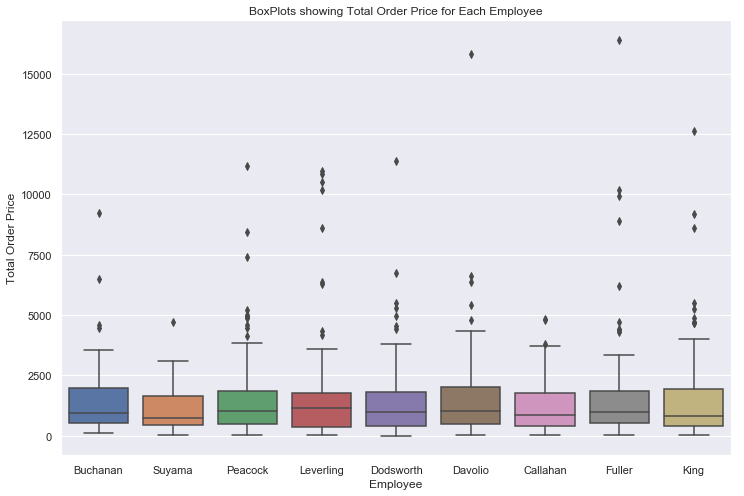

In [7]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='LastName',y='TotalPrice',data=df)
plt.title('BoxPlots showing Total Order Price for Each Employee')
plt.xlabel('Employee');
plt.ylabel('Total Order Price')

Dropping some outliers (any order greater than $5000) which equated to 31 orders

In [8]:
df = df[df.TotalPrice<5000]

Text(0, 0.5, 'Total Order Price')

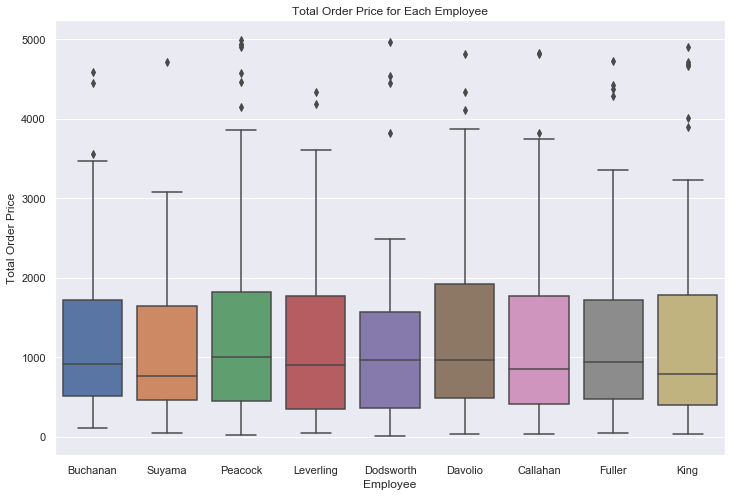

In [9]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='LastName',y='TotalPrice',data=df)
plt.title('Total Order Price for Each Employee')
plt.xlabel('Employee');
plt.ylabel('Total Order Price')

## ANOVA Test

In [10]:
#ANOVA TEST
formula = "TotalPrice ~ C(LastName)"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table['reject_null'] = table['PR(>F)'] < alpha
print(table)

                   sum_sq     df         F    PR(>F)  reject_null
C(LastName)  4.251645e+06    8.0  0.451587  0.889831        False
Residual     9.297212e+08  790.0       NaN       NaN        False


## Tukey Test
See how the employees compare to one-another in terms of Total Price per order

In [11]:
#TUKEY TEST
mc = MultiComparison(df['TotalPrice'], df['LastName'])
result = mc.tukeyhsd()
print("Groups are Employees, summary stats are TotalPrice per Order\n")
#Convert result to dataframe for prettiness and to only show the comparisons that include no-discount
result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print("Multiple Comparison of Means - Tukey HSD,FWER=0.05")
result_df

Groups are Employees, summary stats are TotalPrice per Order

Multiple Comparison of Means - Tukey HSD,FWER=0.05


,group1,group2,meandiff,lower,upper,reject
0,Buchanan,Callahan,-107.8200,-735.6068,519.9668,False
1,Buchanan,Davolio,-0.8546,-617.5528,615.8437,False
2,Buchanan,Dodsworth,-86.6177,-845.9448,672.7093,False
3,Buchanan,Fuller,-64.3407,-704.4624,575.7810,False
4,Buchanan,King,-82.8995,-757.1203,591.3212,False
5,Buchanan,Leverling,-169.0798,-785.1313,446.9716,False
6,Buchanan,Peacock,-7.5983,-607.2187,592.0222,False
7,Buchanan,Suyama,-224.4685,-898.6893,449.7522,False
8,Callahan,Davolio,106.9654,-345.9738,559.9046,False
9,Callahan,Dodsworth,21.2022,-612.3708,654.7752,False


## Histogram of Distributions

In [12]:
employees = ['Davolio','Fuller','Leverling','Peacock','Buchanan','Suyama','King','Callahan','Dodsworth']
employee_order_totals = []
for employee in employees:
    employee_order_totals.append(df.TotalPrice[df.LastName==employee])

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


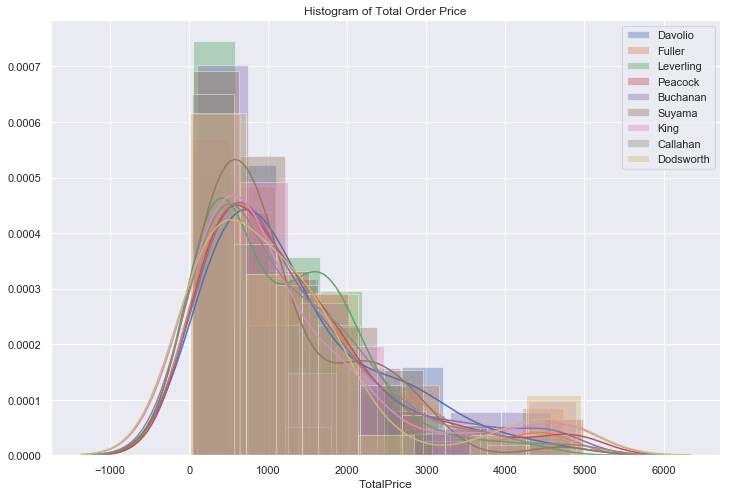

In [13]:
sns.set(rc={'figure.figsize':(12,8)})
for order_total in zip(employee_order_totals,employees):
    sns.distplot(order_total[0], label=order_total[1])
plt.title('Histogram of Total Order Price')
plt.legend()

The sales reps are getting similar revenues per order. There is no statistically significant difference between sales reps. No one sales rep is selling more per order.

Let's investigate total sales per sales rep, just as a curiosity.

In [14]:
#Tables needed: Order, OrderDetail, Employee
query = """SELECT EmployeeId, LastName, FirstName, 
                  count(DISTINCT od.OrderId) AS NumOrders, 
                  sum(od.UnitPrice * od.Quantity * (1-od.Discount)) AS TotalSales
           FROM 
           OrderDetail od 
           JOIN 'Order' o ON o.Id=od.OrderId
           JOIN Employee e ON e.Id=o.EmployeeId
           GROUP BY EmployeeId
           """
summary_df = pd.read_sql(query,conn)
summary_df

,EmployeeId,LastName,FirstName,NumOrders,TotalSales
0,1,Davolio,Nancy,123,192107.6045
1,2,Fuller,Andrew,96,166537.7550
2,3,Leverling,Janet,127,202812.8430
3,4,Peacock,Margaret,156,232890.8460
4,5,Buchanan,Steven,42,68792.2825
5,6,Suyama,Michael,67,73913.1295
6,7,King,Robert,72,124568.2350
7,8,Callahan,Laura,104,126862.2775
8,9,Dodsworth,Anne,43,77308.0665


## Conclusion
Even though some of the employees have a higher number of orders and higher Total Revenue, the quality of their orders remain similar. No one employee stands out here. The difference in total sales per employee is impacted more by number of orders.

Limitations - The total sales per employee may indicate proficiency in generating orders. However we do not know how long each employee has been selling, or the time frame that this data has been collected.